## <center><u>Estimating Hazelnut Biomass and Carbon from Drone LiDAR</u></center>

#### <center> Setup: Install the Conda Environment </center>

To set up the required environment, open a **PowerShell terminal** and run the following command:

```powershell
conda env create -f hazelnut-biomass.yml
```

After creating the environment, click the kernel picker button in the upper-right corner of this notebook in VS Code and select `"Python (hazelnut-biomass)"` as your kernel.

#### <center> Step 1: Pre-processing LiDAR Data (LAS File) </center>

##### Import required libraries

In [17]:
import sys
import os

# Add the project root to sys.path (needs to go up one level since cwd is in notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import lidar_preprocessing.preprocessing as preprocessing
import canopy_segmentation.segmentation as segmentation
import biomass_estimation.biomass as biomass

import laspy
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

##### Helper functions for plotting

In [18]:
def set_axes_equal(ax):
    """Set 3D plot axes to equal scale (cubic aspect ratio)."""
    # Get current limits
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    # Calculate ranges and midpoints
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max([x_range, y_range, z_range])
    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    # Set limits to be centered around the middle
    ax.set_xlim3d([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim3d([y_middle - max_range/2, y_middle + max_range/2])
    ax.set_zlim3d([z_middle - max_range/2, z_middle + max_range/2])

def clean_3d_axes(ax):
    """Remove all background, grid, ticks, and axis labels from a 3D matplotlib plot."""
    # Remove panes
    ax.xaxis.set_pane_color((1, 1, 1, 0))
    ax.yaxis.set_pane_color((1, 1, 1, 0))
    ax.zaxis.set_pane_color((1, 1, 1, 0))
    
    # Remove grid
    ax.grid(False)
    
    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    
    # turn off spines
    ax.set_axis_off()

def plot_point_cloud(
    x, y, z, color_by='z', cmap='viridis', s=0.5, title=None, dist=7,
    norm=None, colorbar_label='Value', ticks=None, ticklabels=None, extra_text=None
):
    """
    Plot a 3D point cloud with optional color mapping.
    Handles both continuous and discrete/categorical color mapping.
    If cmap is a ListedColormap, treats as discrete.
    Pass norm for discrete/categorical mapping.
    """
    import matplotlib.colors as mcolors
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111, projection='3d')
    c = z if (isinstance(color_by, str) and color_by == 'z') else color_by

    # Determine if discrete or continuous based on cmap type or norm
    is_discrete = isinstance(cmap, mcolors.ListedColormap) or norm is not None

    if is_discrete:
        sc = ax.scatter(x, y, z, c=c, cmap=cmap, s=s, norm=norm)
        cbar = plt.colorbar(sc, shrink=0.5, label=colorbar_label, ticks=ticks)
        if ticklabels is not None:
            cbar.ax.set_yticklabels(ticklabels)
    else:
        sc = ax.scatter(x, y, z, c=c, cmap=cmap, s=s)
        plt.colorbar(sc, shrink=0.5, label=colorbar_label)

    set_axes_equal(ax)
    clean_3d_axes(ax)
    ax._dist = dist
    if title:
        ax.set_title(title)
    if extra_text:
        ax.text2D(0.02, 0.98, extra_text, transform=ax.transAxes, fontsize=14,
                  verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))
    plt.show()

def load_masked_raster(raster_path):
    """
    Load a raster and return the data array, transform, and masked array with NoData values masked.
    """
    with rasterio.open(raster_path) as src:
        arr = src.read(1)
        transform = src.transform
        nodata = src.nodata
        if nodata is None:
            nodata = -9999
    masked = np.ma.masked_equal(arr, nodata)
    return arr, transform, masked

def plot_raster_with_overlays(
    raster, transform, cmap='viridis', title=None, colorbar_label='Height (m)',
    points_gdf=None, points_color='red', points_label='Points', points_size=30,
    polygons_gdf=None, polygons_color='red', polygons_label='Polygons', polygons_alpha=0.7, polygons_lw=1.2,
    polygons_column=None 
):
    """
    Plot a raster (e.g., CHM) with optional point and/or polygon overlays.
    - points_gdf: GeoDataFrame of points (optional)
    - polygons_gdf: GeoDataFrame of polygons (optional)
    - polygons_column: Name of column in polygons_gdf to color polygons by (optional)
    """
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    extent = (
        transform[2], transform[2] + transform[0] * raster.shape[1],
        transform[5] + transform[4] * raster.shape[0], transform[5]
    )
    cax = ax.imshow(raster, cmap=cmap, extent=extent)

    legend_handles = []

    # Plot polygons if provided
    polygons_plotted_with_column = False
    if polygons_gdf is not None and not polygons_gdf.empty and polygons_gdf.geometry.notnull().any() and polygons_gdf.geometry.apply(lambda g: not g.is_empty).any():
        if polygons_column is not None and polygons_column in polygons_gdf.columns:
            polygons_gdf.plot(
                ax=ax, column=polygons_column, cmap=cmap, alpha=polygons_alpha, linewidth=polygons_lw,
                edgecolor=polygons_color, legend=True, legend_kwds={'label': colorbar_label}
            )
            polygons_plotted_with_column = True
        else:
            polygons_gdf.boundary.plot(
                ax=ax, edgecolor=polygons_color, linewidth=polygons_lw, alpha=polygons_alpha, label=polygons_label
            )
            legend_handles.append(polygons_label)

    # Plot points if provided
    if points_gdf is not None and not points_gdf.empty and points_gdf.geometry.notnull().any():
        ax.scatter(
            points_gdf.geometry.x, points_gdf.geometry.y,
            color=points_color, s=points_size, label=points_label
        )
        legend_handles.append(points_label)

    if title:
        ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

    # Only add raster colorbar if not plotting polygons by value column
    if not polygons_plotted_with_column:
        fig.colorbar(cax, label=colorbar_label)

    # Only show legend if overlays were plotted and not using polygons_column
    if legend_handles and (polygons_column is None):
        ax.legend()

    plt.show()

##### Load and plot the LAS file

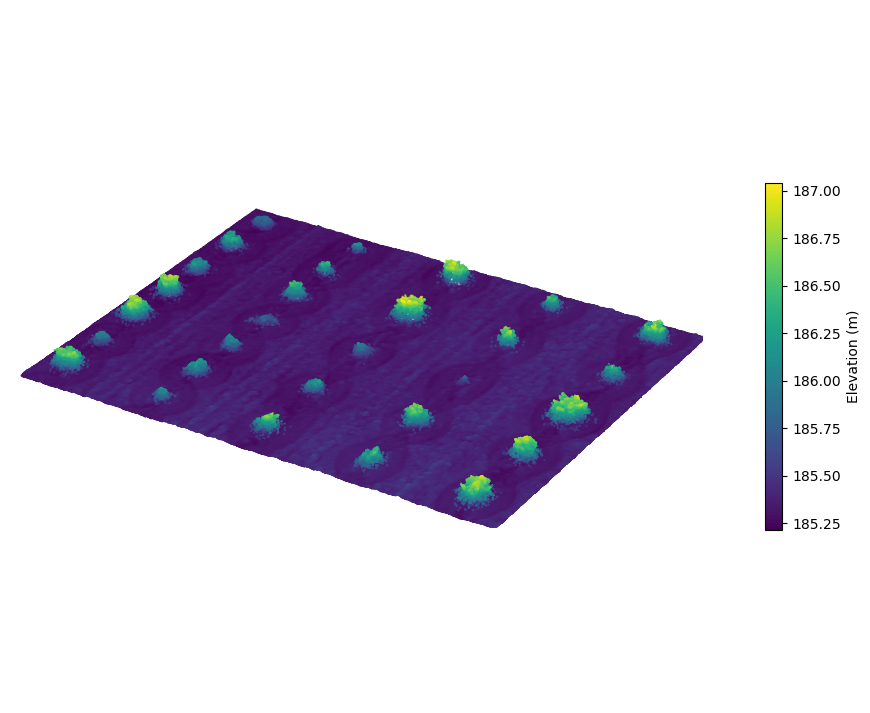

In [19]:
# Load the LAS file
input_folder = "../lidar_preprocessing/sample_data/inputs"
las_file_name = "hazelnuts_valleyFarm_091625_clip.las"
las_file_path = input_folder + "/" + las_file_name
las = laspy.read(las_file_path)

# Plot all points
plot_point_cloud(
    las.x, las.y, las.z,
    color_by='z',
    cmap='viridis',
    s=0.5,
    colorbar_label='Elevation (m)',
    dist=7
)

##### Classify LAS ground

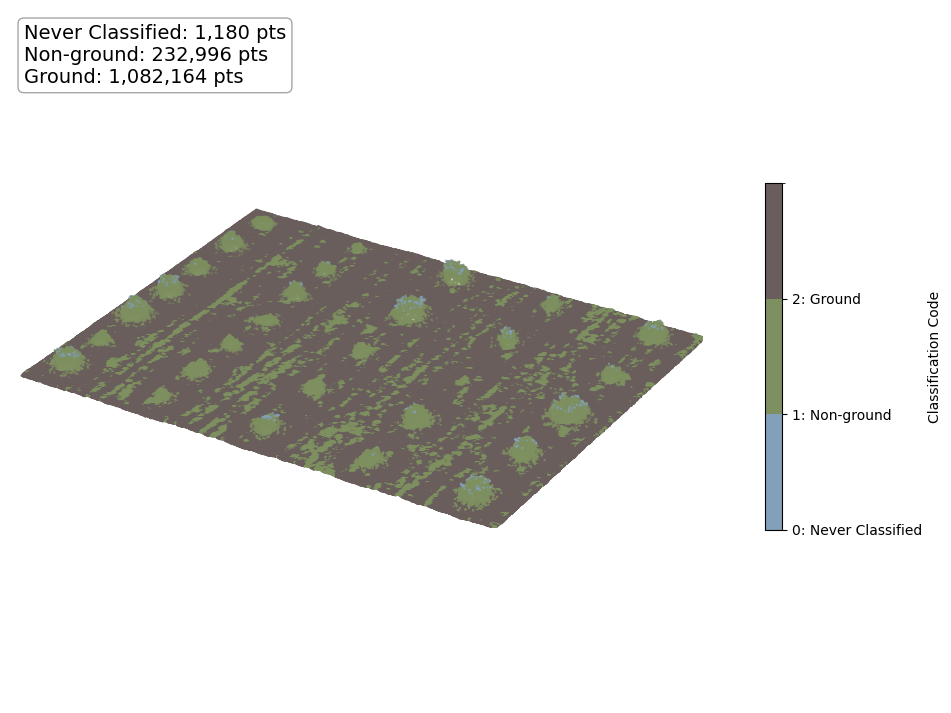

In [20]:
output_folder = "../lidar_preprocessing/sample_data/outputs"
os.makedirs(output_folder, exist_ok=True)  # Creates folder if it doesn't exist

classified_las_name = las_file_name.replace(".las", "_classified.las")
classified_las_path = output_folder + "/" + classified_las_name

# classify ground points using simple morphological (SMRF) filter
preprocessing.classify_ground(
    input_las=las_file_path, 
    output_las=classified_las_path,
    scalar=1.2,
    slope=0.15,
    threshold=0.07,
    window=2.5 # use window size of largest canopy diameter (m)
)

# Load and plot classified LAS file
classified_las = laspy.read(classified_las_path)

# Class mapping and colors
class_names = {
    0: "Never Classified",
    1: "Non-ground",
    2: "Ground"
}
class_colors = ['#83A0BA', '#7E8F60', '#695E5C']  # order: 0, 1, 2
cmap = mcolors.ListedColormap(class_colors)
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Point counts per category
unique, counts = np.unique(classified_las.classification, return_counts=True)
classification_counts = dict(zip(unique, counts))

ticklabels = [f"{i}: {class_names[i]}" for i in range(3)]
counts_text = "\n".join([
    f"{class_names.get(int(cls), 'Unknown')}: {count:,} pts"
    for cls, count in classification_counts.items()
])

plot_point_cloud(
    classified_las.x, classified_las.y, classified_las.z,
    color_by=classified_las.classification,
    cmap=cmap, norm=norm, s=0.5,
    colorbar_label='Classification Code',
    ticks=[0, 1, 2],
    ticklabels=ticklabels,
    extra_text=counts_text,
    dist=7
)

##### Interpolate DTM from classified LAS

Estimated point spacing: 0.0221 m


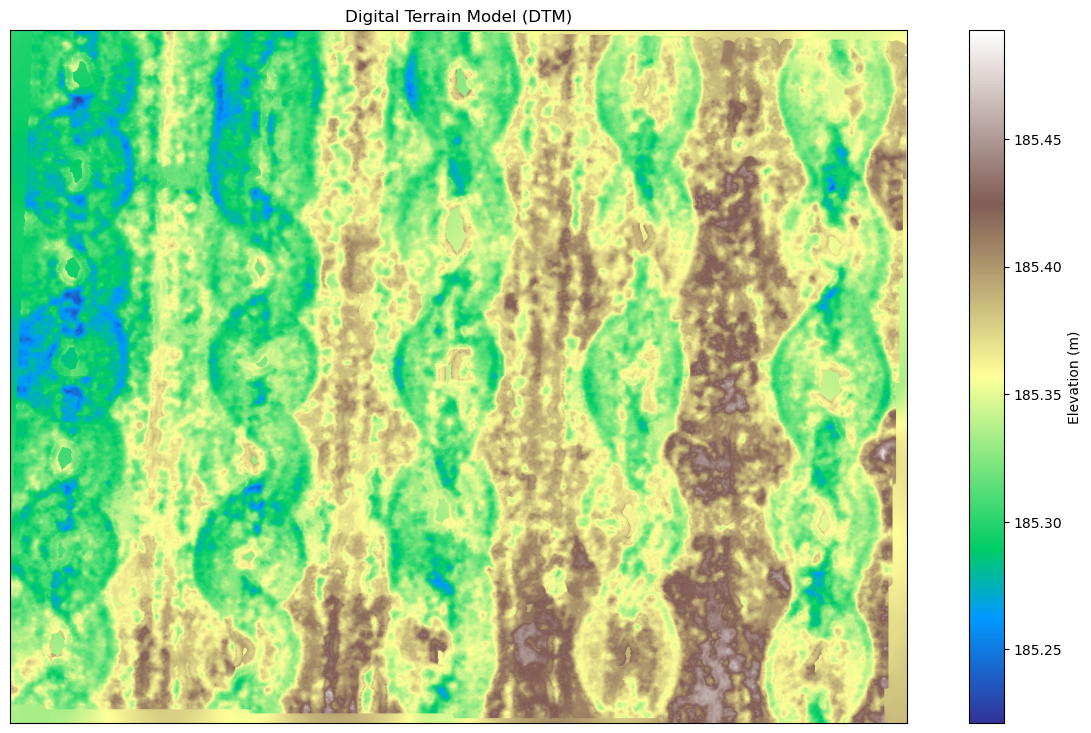

In [21]:
# estimate las point spacing (m) for raster resolution
pt_spacing = preprocessing.estimate_point_spacing(classified_las_path)
print(f"Estimated point spacing: {pt_spacing:.4f} m")

# Interpolate DTM (ground points only)
dtm_raster_path = output_folder + "/" + las_file_name.replace(".las", "_dtm.tif")
preprocessing.create_dtm(
    classified_las=classified_las_path,
    dtm_tif=dtm_raster_path,
    res=pt_spacing
)

# Load DTM
dtm, dtm_transform, dtm_masked = load_masked_raster(dtm_raster_path)

# Plot DTM
plot_raster_with_overlays(
    raster=dtm_masked,
    transform=dtm_transform,
    cmap='terrain',
    title='Digital Terrain Model (DTM)',
    colorbar_label='Elevation (m)'
)

##### Interpolate DSM from classified LAS

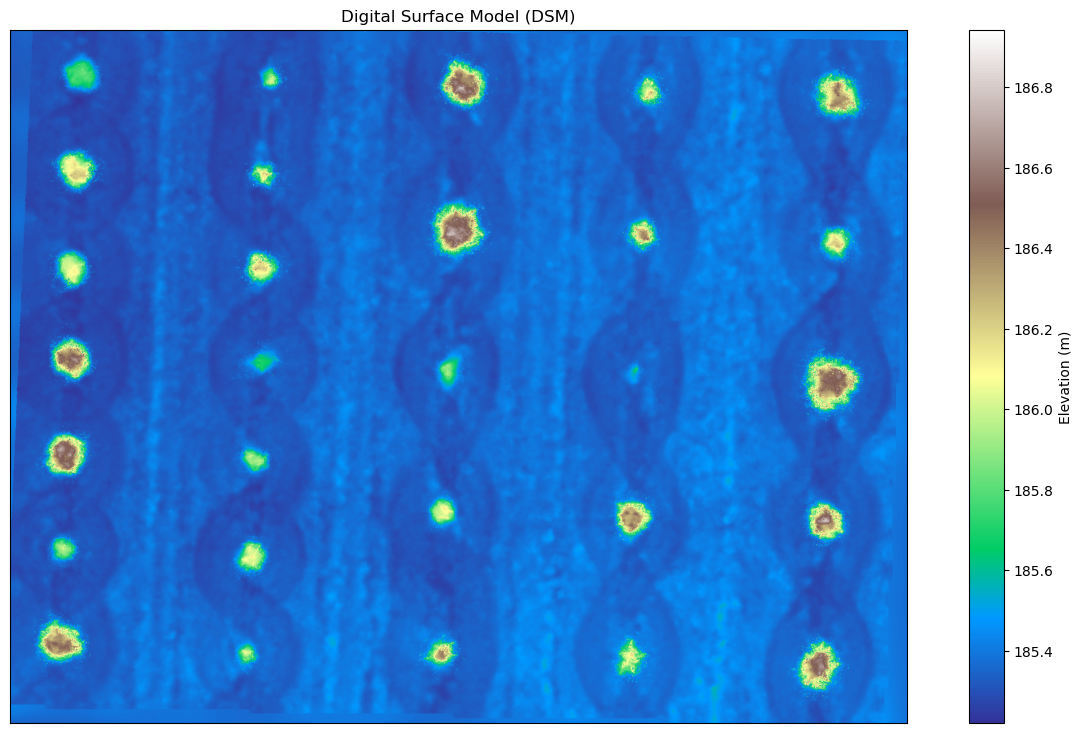

In [22]:
# Interpolate DSM (all points)
dsm_raster_path = output_folder + "/" + las_file_name.replace(".las", "_dsm.tif")
preprocessing.create_dsm(
    classified_las=classified_las_path,
    dsm_tif=dsm_raster_path,
    res=pt_spacing
)

# Load DSM
dsm, dsm_transform, dsm_masked = load_masked_raster(dsm_raster_path)

# Plot DSM
plot_raster_with_overlays(
    raster=dsm_masked,
    transform=dsm_transform,
    cmap='terrain',
    title='Digital Surface Model (DSM)',
    colorbar_label='Elevation (m)'
)

##### Calculate CHM (DSM - DTM)

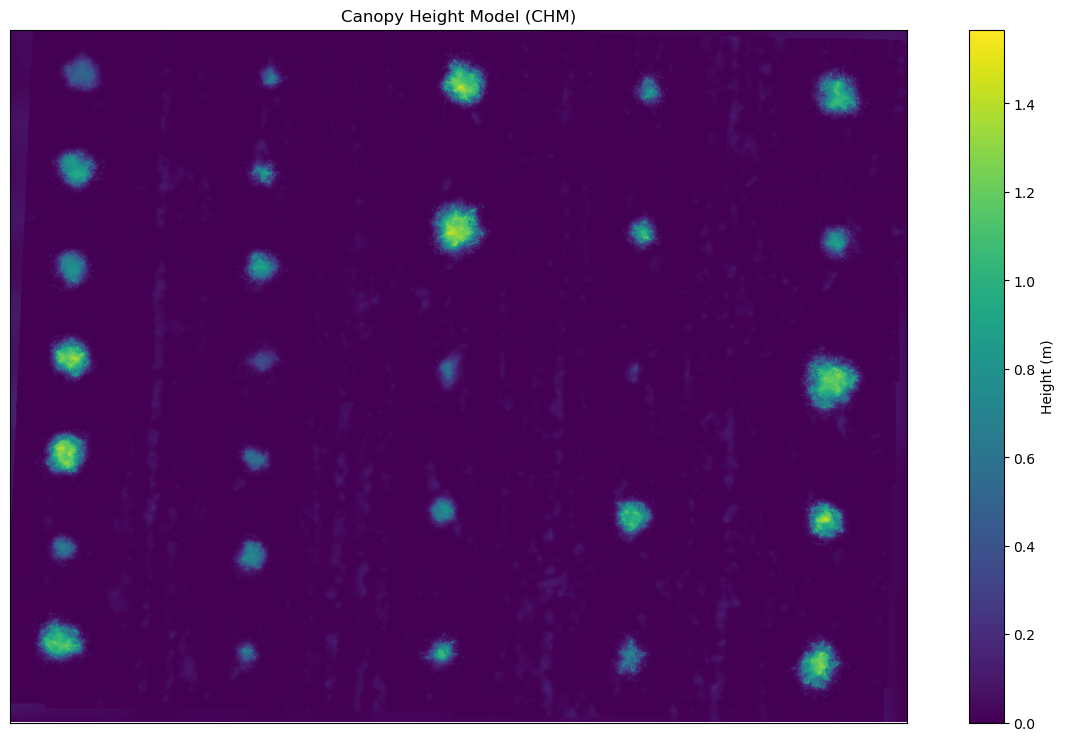

In [24]:
# Calculate CHM
chm_raster_path = output_folder + "/" + las_file_name.replace(".las", "_chm.tif")
preprocessing.create_chm(
    dsm_tif=dsm_raster_path,
    dtm_tif=dtm_raster_path,
    chm_tif=chm_raster_path
)

# Load CHM
chm, chm_transform, chm_masked = load_masked_raster(chm_raster_path)

# Plot CHM
plot_raster_with_overlays(
    raster=chm_masked,
    transform=chm_transform,
    cmap='viridis',
    title='Canopy Height Model (CHM)',
    colorbar_label='Height (m)'
)

#### <center> Step 2: Segmenting Hazelnut Canopies </center>

##### Load hazelnut points and plot on CHM

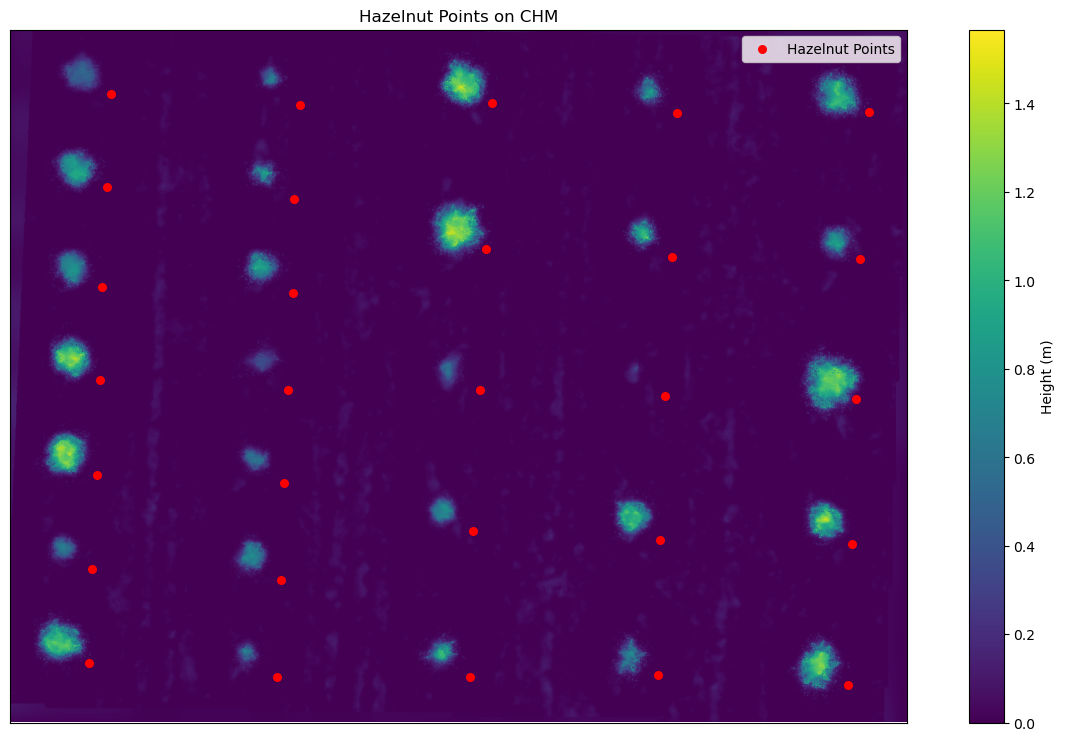

In [25]:
# Load hazelnut markers shapefile
input_folder = "../canopy_segmentation/sample_data/inputs"
hazelnut_markers_path = input_folder + "/hazelnuts_valleyFarm_markers.shp"
hazelnut_markers = gpd.read_file(hazelnut_markers_path)

# Reproject hazelnut markers to match CHM CRS if needed
with rasterio.open(chm_raster_path) as src:
    chm_crs = src.crs
if hazelnut_markers.crs != chm_crs:
    hazelnut_markers = hazelnut_markers.to_crs(chm_crs)

# Plot CHM with hazelnut markers overlaid
plot_raster_with_overlays(
    raster=chm_masked, transform=chm_transform,
    points_gdf=hazelnut_markers,
    points_label='Hazelnut Points',
    title='Hazelnut Points on CHM'
)

##### Refine hazelnut points to local maxima

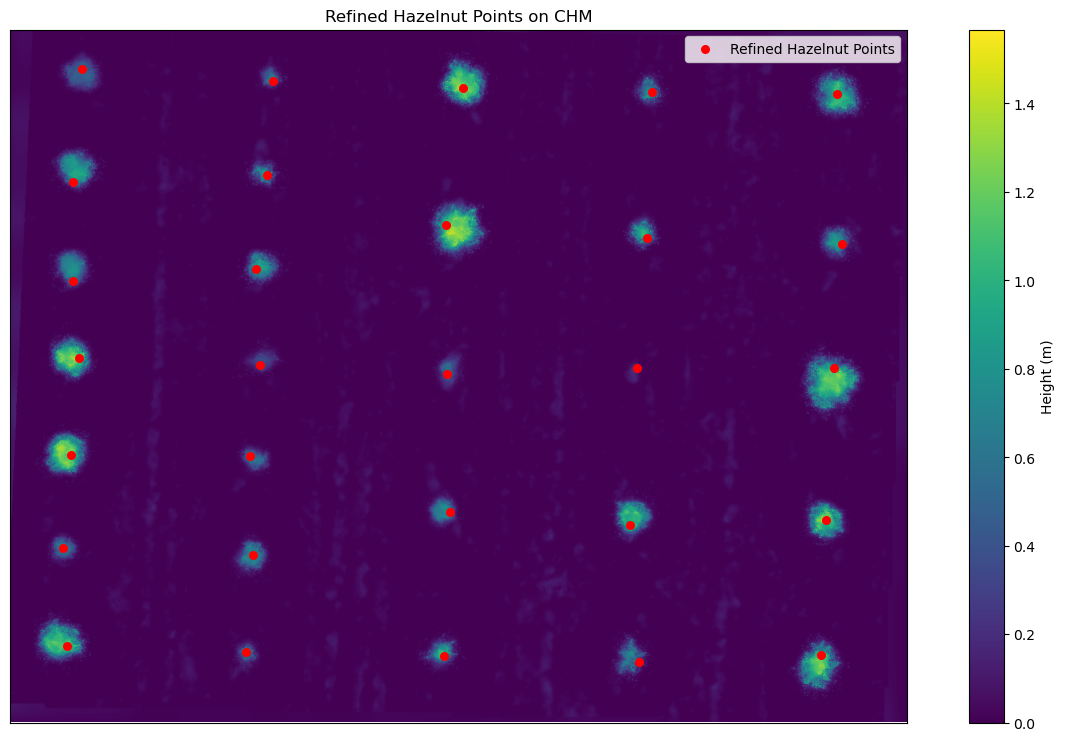

In [ ]:
output_folder = "../canopy_segmentation/sample_data/outputs"
os.makedirs(output_folder, exist_ok=True)

# Load CHM and get its profile and resolution
chm, profile, res_m_per_px, _ = segmentation.load_chm(chm_raster_path)

# Refine hazelnut points to local maxima
refined_rows, refined_cols, markers, refined_gdf = segmentation.refine_tree_tops(
    chm, profile, hazelnut_markers_path, buffer_meters=1.75
)

# Save outputs
segmentation.save_refined_tree_tops(refined_gdf, profile, output_folder)

# Plot refined hazelnut points on CHM
plot_raster_with_overlays(
    raster=chm_masked, transform=chm_transform,
    points_gdf=refined_gdf,
    points_label='Refined Hazelnut Points',
    title='Refined Hazelnut Points on CHM'
)

##### Marker-controlled watershed segmentation

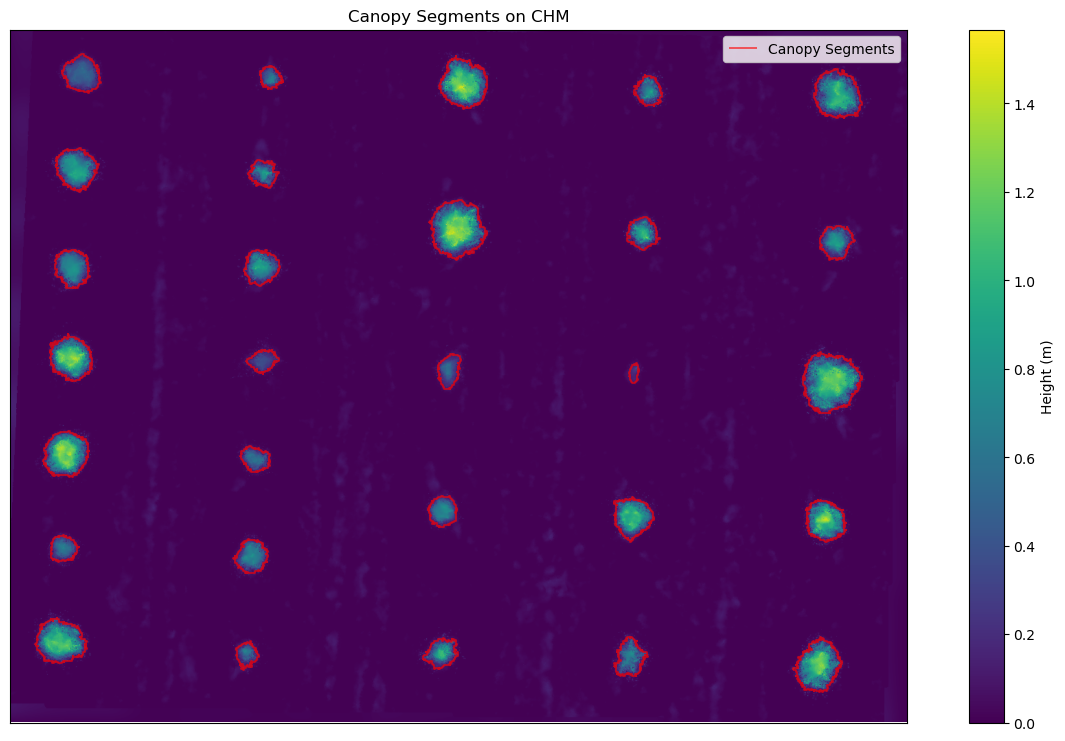

In [30]:
segments = segmentation.adaptive_watershed(
    chm, 
    markers, 
    res_m_per_px,
    profile,
    min_height=0.1 # 10 cm AGL
)

# Save outputs
segmentation.save_segments(
    segments, chm, profile, output_folder, res_m_per_px, refined_gdf=refined_gdf
)

canopy_gdf = gpd.read_file(output_folder + "/" + las_file_name.replace(".las", "_segments.shp"))

# Plot CHM with canopy segments
plot_raster_with_overlays(
    raster=chm_masked, transform=chm_transform,
    polygons_gdf=canopy_gdf,
    polygons_label='Canopy Segments',
    title='Canopy Segments on CHM'
)

#### <center> Step 3: Estimating Biomass and Carbon </center>

##### Calculate hazelnut volumes

In [31]:
# calculate polygon volumes from CHM raster
canopy_gdf = biomass.calculate_polygon_volumes(canopy_gdf, chm_raster_path)
canopy_gdf.head()

tree_id   area_m2     max_h    mean_h   latitude  longitude  row  plant  \
0        1  1.719282  1.251053  0.546593  43.195809 -90.056506   17     26   
1        2  0.826307  0.927689  0.422466  43.195766 -90.056508   17     27   
2        3  2.581114  1.364075  0.661424  43.195726 -90.056507   17     28   
3        4  1.244326  1.460785  0.656760  43.195684 -90.056507   17     29   
4        5  1.672565  1.376389  0.626051  43.195643 -90.056507   17     30   

   cross             id    height  \
0  MWxNJ  MWxNJ_R17_P26  1.251053   
1  MWxNJ  MWxNJ_R17_P27  0.927689   
2  MWxNJ  MWxNJ_R17_P28  1.364075   
3  MWxNJ  MWxNJ_R17_P29  1.460785   
4  MWxNJ  MWxNJ_R17_P30  1.376389   

                                            geometry  volume_m3  
0  POLYGON ((251653.053 4787097.187, 251653.075 4...   0.941870  
1  POLYGON ((251653.119 4787092.157, 251653.273 4...   0.348929  
2  POLYGON ((251652.611 4787088.098, 251652.634 4...   1.709077  
3  POLYGON ((251652.523 4787083.356, 251652.545 4...   0.817809  
4  POLYGON ((251652.589 4787078.966, 251652.634 4...   1.048073

##### Estimate hazelnut biomass and carbon

In [32]:
canopy_gdf = biomass.add_biomass_and_carbon(canopy_gdf)
canopy_gdf.head()

tree_id   area_m2     max_h    mean_h   latitude  longitude  row  plant  \
0        1  1.719282  1.251053  0.546593  43.195809 -90.056506   17     26   
1        2  0.826307  0.927689  0.422466  43.195766 -90.056508   17     27   
2        3  2.581114  1.364075  0.661424  43.195726 -90.056507   17     28   
3        4  1.244326  1.460785  0.656760  43.195684 -90.056507   17     29   
4        5  1.672565  1.376389  0.626051  43.195643 -90.056507   17     30   

   cross             id    height  \
0  MWxNJ  MWxNJ_R17_P26  1.251053   
1  MWxNJ  MWxNJ_R17_P27  0.927689   
2  MWxNJ  MWxNJ_R17_P28  1.364075   
3  MWxNJ  MWxNJ_R17_P29  1.460785   
4  MWxNJ  MWxNJ_R17_P30  1.376389   

                                            geometry  volume_m3    agb_kg  \
0  POLYGON ((251653.053 4787097.187, 251653.075 4...   0.941870  4.402299   
1  POLYGON ((251653.119 4787092.157, 251653.273 4...   0.348929  1.630893   
2  POLYGON ((251652.611 4787088.098, 251652.634 4...   1.709077  7.988225   
3  POLYGON ((251652.523 4787083.356, 251652.545 4...   0.817809  3.822439   
4  POLYGON ((251652.589 4787078.966, 251652.634 4...   1.048073  4.898693   

       c_kg  agb_kg_lo  agb_kg_up   c_kg_lo   c_kg_up  
0  2.289195   3.552655   5.251943  1.847381  2.731010  
1  0.848065   1.316131   1.945656  0.684388  1.011741  
2  4.153877   6.446497   9.529952  3.352179  4.955575  
3  1.987668   3.084708   4.560170  1.604048  2.371288  
4  2.547320   3.953245   5.844141  2.055687  3.038953

##### Save results to .shp and .csv

In [ ]:
output_folder = "../biomass_estimation/sample_data/outputs"
os.makedirs(output_folder, exist_ok=True) 

biomass.save_results(
    canopy_gdf,
    os.path.join(output_folder, las_file_name.replace(".las", "_biomass_results.shp")),
    os.path.join(output_folder, las_file_name.replace(".las", "_biomass_results.csv"))
)

##### Plot hazelnut biomass

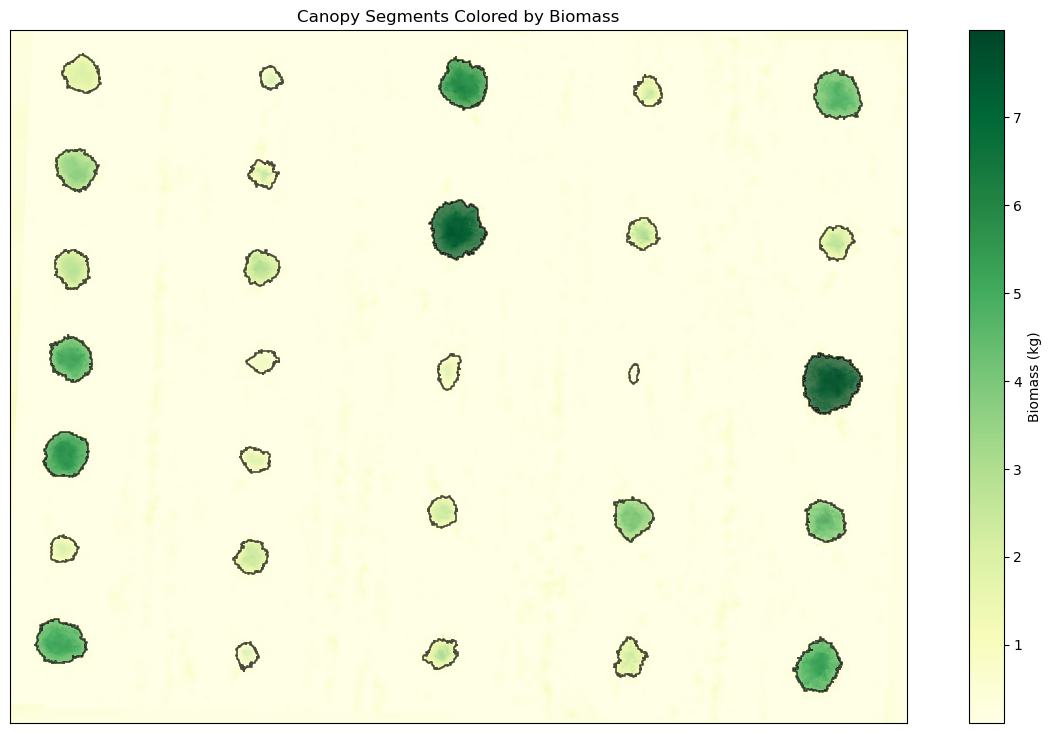

In [34]:
plot_raster_with_overlays(
    raster=chm_masked, transform=chm_transform,
    polygons_gdf=canopy_gdf,
    polygons_label='Canopy Segments',
    title='Canopy Segments Colored by Biomass',
    cmap='YlGn',
    colorbar_label='Biomass (kg)',
    polygons_color='black',
    polygons_alpha=0.7,
    polygons_column='agb_kg'  
)

##### Plot hazelnut carbon

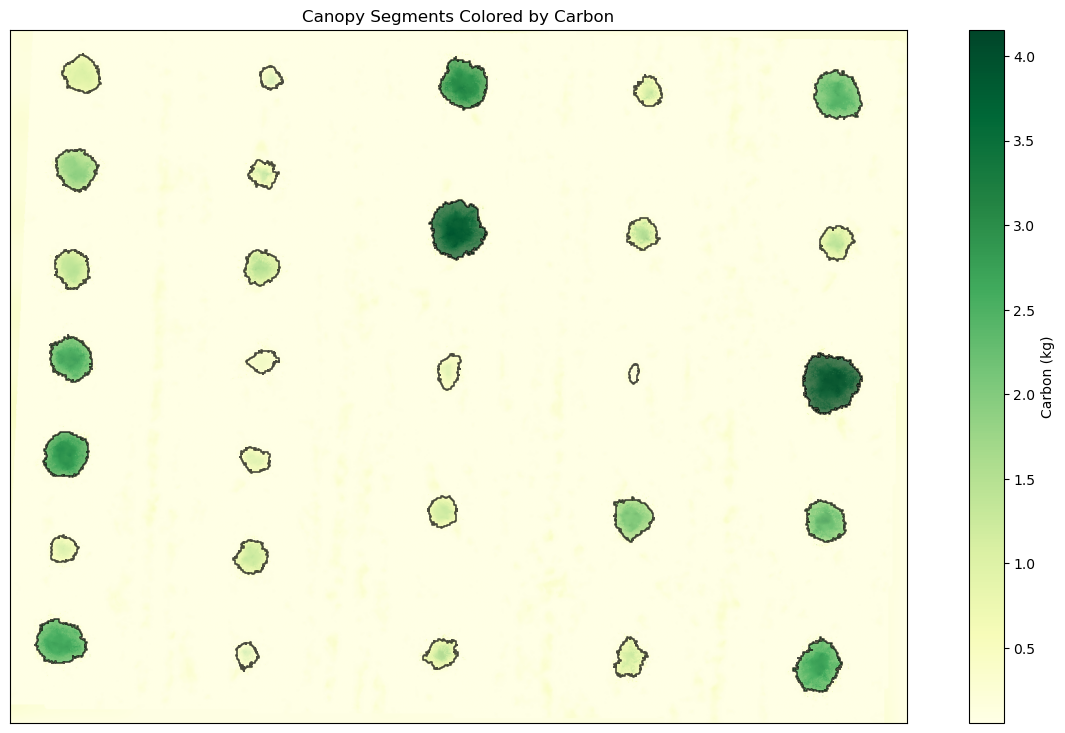

In [35]:
plot_raster_with_overlays(
    raster=chm_masked, transform=chm_transform,
    polygons_gdf=canopy_gdf,
    polygons_label='Canopy Segments',
    title='Canopy Segments Colored by Carbon',
    cmap='YlGn',
    colorbar_label='Carbon (kg)',
    polygons_color='black',
    polygons_alpha=0.7,
    polygons_column='c_kg'
)